In [1]:
import numpy as np
import scipy
import mlpp.pp.hawkes as hk
from mlpp.base.utils import TimeFunction
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset to simulate 

In [12]:
kernel = 'exp'
d = 10
symmetric = True
T = 1e5

In [13]:
if symmetric:
    mode = 'd' + str(d) + '_sym'
else:
    mode = 'd' + str(d) + '_nonsym'

## Major key for exp kernel: 
### Since hMax=40 encodes the support, we ensure \beta is not too small for estimation
Criterion on exp kernel gives us $\beta_{\min}$ such that $$\exp(-\mbox{hMax} \times \beta_\min) = 10^{-4}$$

In [14]:
hMax = 40
from math import log
beta_min = log(1000) / hMax
print("We have")
print("    beta_min = ",beta_min)

We have
    beta_min =  0.17269388197455343


In [15]:
mode = 'd10_sym'

In [16]:
if mode == 'd10_sym':
    d = 10
    mu = 0.0001 * np.ones(d)
    Alpha = np.zeros((d,d))
    Beta = np.zeros((d,d))
    Gamma = np.zeros((d,d))
    Alpha[:d/2,:d/2] += 1.
    Alpha[d/2:,d/2:] += 1.
    Beta[:d/2,:d/2] += 1000*beta_min
    Beta[d/2:,d/2:] += 10*beta_min
    # add noise
    #Alpha += 0.01
    Alpha[6:8,:3] += 3.
    Beta[6:8,:3] += 100*beta_min
    Alpha = .5*(Alpha+Alpha.T)
    Gamma = .5*Alpha
    Beta = .5*(Beta + Beta.T)
    Alpha /= 12

elif mode == 'd10_nonsym':
    d = 10
    mu = 0.0001 * np.ones(d)
    Alpha = np.zeros((d,d))
    Beta = np.zeros((d,d))
    Gamma = np.zeros((d,d))
    for i in range(5):
        for j in range(5):
            if i <= j:
                Alpha[i][j] = 1.
                Beta[i][j] = 1000*beta_min
    for i in range(5,10):
        for j in range(5,10):
            if i >= j:
                Alpha[i][j] = 1.
                Beta[i][j] = 10*beta_min
    Gamma = .5*Alpha
    Alpha /= 6

elif mode == 'd100_sym':
    d = 100
    mu = 0.0001 * np.ones(d)
    Alpha = np.zeros((d,d))
    Beta = np.zeros((d,d))
    Gamma = np.zeros((d,d))
    Alpha[:d/2,:d/2] += 1.
    Alpha[d/2:,d/2:] += 1.
    Beta[:d/2,:d/2] += 1000*beta_min
    Beta[d/2:,d/2:] += 10*beta_min
    #add noise
    #Alpha += 0.01
    Alpha[60:70,10:20] += 3.
    Alpha = .5*(Alpha+Alpha.T)
    Beta[60:70,10:20] += 100*beta_min
    Beta = .5*(Beta + Beta.T)
    Gamma = .5*Alpha
    Alpha /= 120

elif mode == 'd100_nonsym':
    d = 100
    mu = 0.0001 * np.ones(d)
    Alpha = np.zeros((d,d))
    Beta = np.zeros((d,d))
    Gamma = np.zeros((d,d))
    for i in range(40):
        for j in range(40):
            if i <= j:
                Alpha[i][j] = 1.
                Beta[i][j] = 10*beta_min
    for i in range(41,60):
        for j in range(41,60):
            Alpha[i][j] = 1.
            Beta[i][j] = (100+900*np.random.rand())*100.*beta_min
    for i in range(61,100):
        for j in range(61,100):
            if i >= j:
                Alpha[i][j] = 1.
                Beta[i][j] = 100.*beta_min
    Gamma = .5*Alpha
    Alpha /= 30

/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


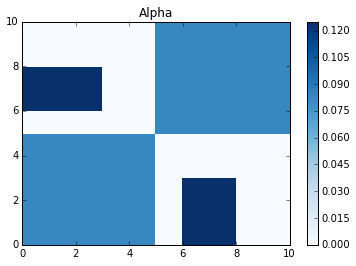

In [17]:
plt.pcolor(Alpha,cmap=plt.cm.Blues)
plt.title("Alpha")
plt.colorbar()
plt.show()
plt.close()

/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


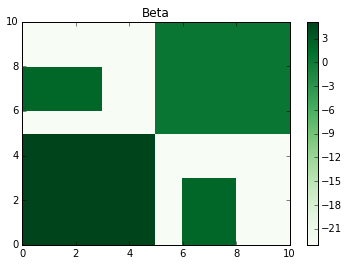

In [18]:
eps = 1e-10
plt.pcolor(np.log(eps+Beta),cmap=plt.cm.Greens)
plt.title("Beta")
plt.colorbar()
plt.show()
plt.close()

## Simulation of the process

### Design rectangular kernel

In [19]:
Phi_norm = np.zeros_like(Alpha)

if kernel == 'exp':
    kernels = [[hk.HawkesKernelExp(a, b) for (a, b) in zip(a_list, b_list)] for (a_list, b_list) in zip(Alpha, Beta)]
    Phi_norm = Alpha.copy()

elif kernel == 'plaw':
    def kernel_plaw(alpha,beta,gamma,support=-1):
        """
        Alternative definition.
        phi(t) = alpha * beta / (1 + beta t) ** (1 + gamma)
        """
        if beta > 0:
            return hk.HawkesKernelPowerLaw(alpha/(beta**gamma),1./beta,1.+gamma,support)
        else:
            return hk.HawkesKernelPowerLaw(0.,1.,1.,support)
    kernels = [[kernel_plaw(a*g, b, g, -1) for (a, b, g) in zip(a_list, b_list, g_list)] for (a_list, b_list, g_list) in zip(Alpha, Beta, Gamma)]
    Phi_norm = Alpha.copy()

elif kernel == 'rect':
    def kernel_rect(alpha, beta, gamma):
        if beta > 0:
            T = np.array([0, gamma, gamma + 1./beta ], dtype=float)
            Y = np.array([0, alpha*beta,0], dtype=float)
            tf = TimeFunction([T, Y], inter_mode=TimeFunction.InterConstRight)
            return hk.HawkesKernelTimeFunc(tf)
        else:
            T = np.array([0, 1, 1.5 ], dtype=float)
            Y = np.array([0, 0, 0], dtype=float)
            tf = TimeFunction([T, Y], inter_mode=TimeFunction.InterConstRight)
            return hk.HawkesKernelTimeFunc(tf)
    kernels = [[kernel_rect(a, b, g) for (a, b, g) in zip(a_list, b_list, g_list)] for (a_list, b_list, g_list) in zip(Alpha, Beta, Gamma)]
    Phi_norm = Alpha.copy()

### Check if $||\Phi||$, can generate a stable Hawkes process

In [20]:
_, s, _ = np.linalg.svd(Phi_norm)
print(s.max())
assert s.max() < 1, "Alpha cannot generate a stable Hawkes process"

0.618702408408


In [21]:
h = hk.Hawkes(kernels=kernels, mus=list(mu))
h.simulate(T)

## Use the class Cumulants

In [22]:
from utils.cumulants import Cumulants
N = h.get_full_process()
cumul = Cumulants(N,hMax=16)
# compute everything
cumul.compute_all()
from scipy.linalg import inv
R_true = inv(np.eye(d)-Phi_norm)
cumul.set_R_true(R_true)
cumul.set_C_th()
cumul.set_K_th()
cumul.compute_B()
cumul.set_K_part()
cumul.set_K_part_th()

In [23]:
from utils.metrics import rel_err
print(rel_err(cumul.C_th,cumul.C))
print(rel_err(cumul.K_th,cumul.K))
print(rel_err(cumul.K_part_th,cumul.K_part))

0.525963060918
0.679263833733
0.592210606293


In [ ]:
with_Beta = True
without_N = True

if with_Beta and without_N:
    cumul.N = None
    data = (cumul,Beta)
    import gzip, pickle
    f = gzip.open('datasets/' + mode + '_with_Beta_without_N.pkl.gz','wb')
    pickle.dump(data, f, protocol=2)
    f.close()
    cumul.N = h.get_full_process()
    
elif with_Beta and not without_N:
    data = (cumul,Beta)
    import gzip, pickle
    f = gzip.open('datasets/' + mode + '_with_Beta.pkl.gz','wb')
    pickle.dump(data, f, protocol=2)
    f.close()
    
elif not with_Beta and without_N:
    cumul.N = None
    import gzip, pickle
    f = gzip.open('datasets/' + mode + '_without_N.pkl.gz','wb')
    pickle.dump(cumul, f, protocol=2)
    f.close()
    cumul.N = h.get_full_process()

elif not with_Beta and not without_N:
    import gzip, pickle
    f = gzip.open('datasets/' + mode + '.pkl.gz','wb')
    pickle.dump(cumul, f, protocol=2)
    f.close()